In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier, plot_importance

# Dane

In [3]:
DATA_PATH = "Datasets/HCMST 2017 fresh sample for public sharing draft v1.1.dta"

In [4]:
df = pd.read_stata(DATA_PATH)

In [5]:
target = ["S1"]
cat_feat = ['hcm2017q24_internet_other', 'PPT01']
float_feat = ['Q16', 'age_when_met']
feat = cat_feat + float_feat + target

In [6]:
df = df[feat]
df = df.dropna()
df[cat_feat] = df[cat_feat].apply(lambda x: x.cat.codes, axis=0)
df[target] = (df[target] == "Yes, I am Married").astype(int)

In [7]:
df_X = df[feat[:-1]]
df_y = df[target]

# Model

In [8]:
X = df_X.values
y = df_y.values

In [9]:
fix_params = {'objective': 'binary:logistic', "seed": 42}
param_dist = {
    'n_estimators': stats.randint(150, 500),
    'learning_rate': np.linspace(0.01,0.1, 10),
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'colsample_bytree': stats.uniform(0.5, 0.45),
    'min_child_weight':[1, 2, 4, 6, 8, 10, 12],
    'gamma':[i/10.0 for i in range(0,5)]
             }
clf = RandomizedSearchCV(estimator=XGBClassifier(**fix_params), param_distributions = param_dist, n_iter = 25, scoring = 'f1', cv=5, n_jobs = -1)
clf.fit(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=25, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efca6a73518>, 'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]), 'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efca6a74b70>, 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_child_weight': [1, 2, 4, 6, 8, 10, 12], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
          pre_dispatch='

In [10]:
best_params = {**clf.best_params_, **fix_params}
clf_xgb = XGBClassifier(**best_params)
clf_xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8864708066426088, gamma=0.3, learning_rate=0.01,
       max_delta_step=0, max_depth=9, min_child_weight=10, missing=None,
       n_estimators=303, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

# M-Plot

In [11]:
def m_plot(model, S, data):
    dependency = []
    for x in data[S].values:
        data_copy = data.copy()
        data_copy[S] = x
        res = model.predict_proba(data_copy.values)[:,1]
        dist = np.array([np.isin(data.values, row).all(axis=1).sum() for row in data_copy.values])
        dist = dist/dist.sum()
        est = np.dot(res, dist)
        dependency.append([x,est])
    
    dependency = np.array(sorted(dependency, key=lambda y: y[0]))
    plt.grid(linewidth=0.25)
    plt.xlabel("feature: {}".format(S[0]))
    plt.ylabel("marriage probability")
    plt.plot(dependency[:, 0], dependency[:, 1])

In [12]:
idx = np.random.choice(np.arange(df_X.shape[0]), size=50, replace=False)

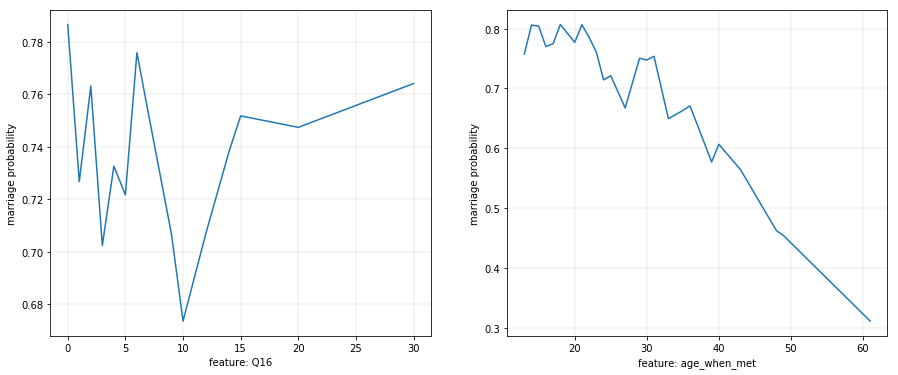

In [13]:
fig = plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
m_plot(model=clf_xgb, S=float_feat[:1], data=df_X.iloc[idx])

plt.subplot(1, 2, 2)
m_plot(model=clf_xgb, S=float_feat[1:], data=df_X.iloc[idx])

plt.show()

`Pierwszy nie rozni sie zbytnio pod względem trendu, natomiast przy drugim widac znaczącą wariancję. 
Wnioski te jednak nie są informatywne, ponieważ w zadaniu pierwszym dobralem zakres cech losowo, natomiast tu korzystalem z dostarczonych danych by uwzglednic rozklad. 

# ALE-Plot

In [14]:
def ale_plot(model, S, df, k=50):
    estimator = []
    points = np.linspace(df[S].min(), df[S].max(), 20)
    df_c = df.copy()
    bound = df_c[S].quantile(np.linspace(0, 1, k+1)).values
    df_c["which_interval"] = df_c[S].apply(lambda x: (x <= bound[1:]).argmax())
    df_c_grouped = df_c.groupby(by="which_interval")
    for x in points:
        est = 0
        for i, sub_df in df_c_grouped:
            sub_df = sub_df.drop(columns=["which_interval"])
            df_c1 = sub_df.copy()
            df_c2 = sub_df.copy()
            df_c1[S] = bound[i]
            df_c2[S] = bound[i+1]
            res = (model.predict_proba(df_c2.values)[:,1] - model.predict_proba(df_c1.values)[:,1]).sum() / sub_df.shape[0]
            est += res
            if bound[i+1] >= x:
                break
                
        estimator.append((x, est))
    
    estimator = np.array(estimator)
    estimator[:, 1] -= estimator[:,1].mean()
    plt.grid(linewidth=0.25)
    plt.xlabel("feature: {}".format(S))
    plt.ylabel("marriage probability centralized")
    plt.plot(estimator[:, 0], estimator[:, 1])
    
        

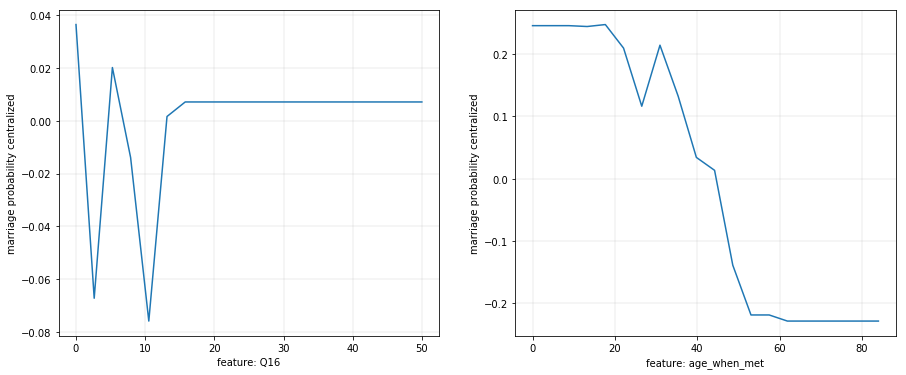

In [15]:
K = 50
fig = plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
ale_plot(clf_xgb, S=float_feat[0], df=df_X, k=K)

plt.subplot(1, 2, 2)
ale_plot(clf_xgb, S=float_feat[1], df=df_X, k=K)

plt.show()